<a href="https://colab.research.google.com/github/cphchip/cs8321_code/blob/test/Lab%202/Henderson_48996654_Lab_2a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cs8321 Lab 2 - Transfer Learning and Transformers

#### Chip Henderson - 48996654

## [2.0 points] Dataset Overview

In this dataset, I'll be working on a sentiment classification. This is a many to one classifier of Amazon reviews. I'll be working with categories of negative, netral, and positive.

Thhis version of the Amazon reviews dataset is was updated in 2018 from an original version in 2014. It consists of more than 230 million customer reviews from 1996 to 2018.

**What is the feature data? Who collected the data? Why? When? Is it multimodal?**

**What evaluation criteria will you be using, why?**

## [2.0 points] Describe the foundational model that you will be using to transfer learn from

I'll be using the bert-base-uncased model for my foundation model. This model's architecture consists of:
* 12 layers
* 768 hidden
* 12-heads
* 110 million parameters

and trained on lower-cased English text per the [hugging face repo](https://huggingface.co/transformers/v3.3.1/pretrained_models.html).

**What tasks was the foundational model trained from?**

Per the hugging face [blog site](https://huggingface.co/google-bert/bert-base-uncased?text=The+goal+of+a+dog%27s+life+is+%5BMASK%5D), "the BERT model was pretrained on BookCorpus, a dataset consisting of 11,038 unpublished books and English Wikipedia. It is also known as the Toronto Book Corpus, and consists of the text of around 7,000 self-published books scraped from the indie ebook distribution website Smashwords [per wikipedia](https://en.wikipedia.org/wiki/BookCorpus). The dataset consists of around 985 million words across a large span of genres.

**Explain if the new task is within the same domain, across domains, etc.**

## [1.0 points] Split the data into training and testing

We'll start by importing the data from the source. I'll use a pandas dataframe initially due to its ease of understanding the labels and data types in the dataset.

In [ ]:
# Uncomment for use in colab
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%%time
# Source: modified from https://nijianmo.github.io/amazon/index.html for
# importing data. Customized path and df name
import pandas as pd
import gzip
import json

# path = "../Data_sources/Video_Games_5.json.gz" # local
path = "/content/drive/MyDrive/Colab Notebooks/Data_sources/Video_Games_5.json.gz" # colab

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

init_df = getDF(path)


CPU times: user 12.5 s, sys: 1.38 s, total: 13.9 s
Wall time: 14.4 s


In [ ]:
init_df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4.0,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3.0,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2.0,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5.0,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


### Dimensionality Reduction

This is a big dataset, and there are a number of columns I don't need. To keep operations faster I'm going to drop everything I don't need.

In [ ]:
features_to_keep = ['overall','reviewText']
features_to_drop = [feature for feature in init_df.columns if feature not in features_to_keep]
df = init_df.drop(features_to_drop,axis=1)

del init_df # memory management
df.head()

,overall,reviewText
0,5.0,"This game is a bit hard to get the hang of, bu..."
1,4.0,I played it a while but it was alright. The st...
2,3.0,ok game.
3,2.0,"found the game a bit too complicated, not what..."
4,5.0,"great game, I love it and have played it since..."


In [ ]:
# df = df.sample(frac=0.01,replace=False) # local
df = df.sample(frac=0.1,replace=False) # local or colab

# Colab could run 5% of the data but it completely maxed out the 51 GB of RAM
# df = df.sample(frac=0.05,replace=False) # colab
df.reset_index(drop=True,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49758 entries, 0 to 49757
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   overall     49758 non-null  float64
 1   reviewText  49746 non-null  object 
dtypes: float64(1), object(1)
memory usage: 777.6+ KB


I'm also going to remove any stop words from the review text. Stop words are words like "a,” “the,” “is,” “are," and don't add a lot of contextual value. So they're a good way to reduce the size of the reviews. Before I can do that I need to make sure there aren't any unrecognized characters so I'll do some additional processing on the review text.

In [ ]:
# The text of this dataset was an object datatype and wouldn't process as strings
# So I'll need to convert it to a string
df['reviewText'] = df['reviewText'].str.strip()
df['str_reviewText'] = df['reviewText'].astype(str)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49758 entries, 0 to 49757
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         49758 non-null  float64
 1   reviewText      49746 non-null  object 
 2   str_reviewText  49758 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [ ]:
%%time
# Use NLTK to remove stopwords
import nltk
# import re
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

def remove_stop_words(review):
    # no_tags = re.sub(pattern,'',tweet)
    no_stop_words = [word for word in review.split() if word not in stop_words]
    return ' '.join(no_stop_words)


# Apply the pattern to remove those tags from tweets
df['str_reviewText'] = df['str_reviewText'].apply(remove_stop_words)
df['reviewText'].drop

print(df['str_reviewText'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0        Quite possibly viscerally scary game I've play...
1        Having read negative reviews I brought game I ...
2        I find game one greatest rpg games I've ever p...
3        Playing DW5 Xtreme Legend real let down. Almos...
4        It's great challenging game corny, fun story. ...
                               ...                        
49753                                                 good
49754    The graphics different makes game great stands...
49755    Pretty useless unless Hobbit sized hands. Use ...
49756    For me, I stopped playing since Tekken 3 Tag T...
49757    like brand new great shipping time literally b...
Name: str_reviewText, Length: 49758, dtype: object
CPU times: user 2.99 s, sys: 4.06 s, total: 7.05 s
Wall time: 3.47 s


Strangely, these don't all seem like electronics reviews...but for my purposes it really doesn't matter. Also, there's no obvious sentiment labels in the dataset. So I'm going to use the overall rating as my sentiments. I'll set up the following categories:
 -  0-2: Negative
 -  3: Neutral
 -  4-5: Positive

After grouping, I'll plot the distributions using a pie chart to visually observe how many samples are in each group.

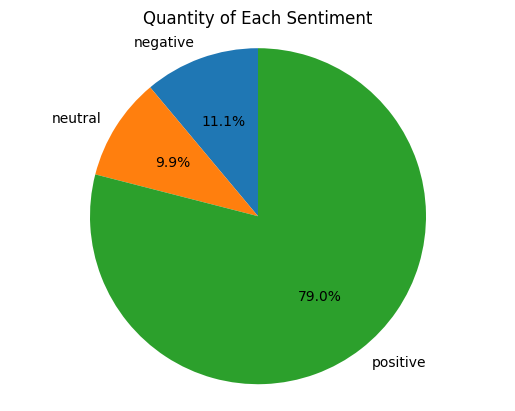

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

# Bracket the sentiments based on Overall value
df['sentiment'] = pd.cut(df['overall'], [0,2,3,5], labels=['negative','neutral','positive'])

# Group the data by sentiment for purposes of charting
sentiments = df.groupby(['sentiment'])
pie_data = sentiments.size()

# Set the pie chart parameters
plt.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', labeldistance=1.1, startangle=90)

plt.title("Quantity of Each Sentiment")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# Get the exact count of each value to provide further information
df.value_counts(['sentiment'])

del sentiments # memory management

There is a significant misbalance of my classes, so I'm going to need to make sure I stratify the data so that the data is well represented. Before I do that, I'll tokenize the reviews and and prepare the data for splitting by narrowing down to fields of interest.

To get started with tokenizing, I need to know the max length I'll encounter in the reviews.

In [ ]:
# Determine longest review length
# print(f"The longest review is {len(max(df['str_reviewText'], key=len))} characters")
print(f"The longest review is {max(len(review.split()) for review in df['str_reviewText'])} words")


The longest review is 3206 words


To the extent possible, I'm going to keep my initial model and my BERT model on equal footing. The BERT model has a token limit of 512. But, I quickly learned that trying to run the max through BERT was very time consuming on my hardware. Therefore I'll limit my max length to be 50 for my models.

In [ ]:
%%time
# Source: cs7324 lab 7
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

NUM_TOP_WORDS = None # use entire vocabulary!
MAX_REVIEW_LEN = 3000 # limit to 100 words

#tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(df['str_reviewText'])
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(df['str_reviewText'])

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_REVIEW_LEN)
y = df.sentiment.values
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y.shape)
print(np.max(X))


Found 67908 unique tokens. Distilled to 67908 top words.
Shape of data tensor: (49758, 3000)
Shape of label tensor: (49758,)
67908
CPU times: user 8.44 s, sys: 792 ms, total: 9.23 s
Wall time: 9.2 s


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size=0.2, stratify=y)

In [ ]:
# Source: in class lecture notebook cs7324 13a
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras

# Use label encoder to get my data into integer form
label_encoder = LabelEncoder()
y_enc_train = label_encoder.fit_transform(y_train)
y_enc_test = label_encoder.fit_transform(y_test)

# One-hot encode the encoded labels
y_train_ohe = keras.utils.to_categorical(y_enc_train)
y_test_ohe = keras.utils.to_categorical(y_enc_test)

# Check the shape of the data and labels to ensure they are correct
print('Shape of data tensor train:', X_train.shape)
print('Shape of data tensor for test:', X_test.shape)
print('Shape of label tensor train:', y_train_ohe.shape)
print('Shape of label tensor for test:', y_test_ohe.shape)

Shape of data tensor train: (39806, 3000)
Shape of data tensor for test: (9952, 3000)
Shape of label tensor train: (39806, 3)
Shape of label tensor for test: (9952, 3)


**explain how you performed this operation and why you think it is reasonable to split this particular dataset this way**

**For multi-task datasets, be sure to explain if it is appropriate to stratify within each task.**

**If the dataset is already split for you, explain how the split was achieved and how it is stratified.**

## [2.0 points] Train a model from scratch to perform the classification task (this does NOT need to be a transformer).

**Verify the model converges (even if the model is overfit).**

#### Convolutional Neural Network 1 (CNN-1)

The first CNN I'll run will consist of 64 filters with a width of 5. I'm changing the filter size from the in-class example because my dataset is quite a bit smaller. So my thought being I won't need so many filters to get good results.

In [ ]:
%%time
# Source: Modified from in-class lecture notebook 13a
EMBED_SIZE = 300
# the embed size should match the file you load glove from
embeddings_index = {}
# f = open(r'../Data_sources/glove.6B.300d.txt') # local
f = open(r'/content/drive/MyDrive/Colab Notebooks/Data_sources/glove.6B.300d.txt') # colab
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
    "Total words found:",found_words, "\n",
    "Percentage:",100*found_words/embedding_matrix.shape[0])

Found 400000 word vectors.
Embedding Shape: (67909, 300) 
 Total words found: 42934 
 Percentage: 63.222842333122266
CPU times: user 24.4 s, sys: 1.43 s, total: 25.8 s
Wall time: 26 s


In [ ]:
# Source: Modified from in-class notebook 13a
# save this embedding now
from tensorflow.keras.layers import Embedding, Input, Concatenate
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_REVIEW_LEN,
                            trainable=False)

In [ ]:
NUM_CLASSES = 3 # positive, negative, neutral
EMBED_SIZE = 300 # same size as loaded from GLOVE

from tensorflow.keras.metrics import Precision
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Subtract

In [ ]:
from keras.callbacks import CSVLogger

csv_logger_cnn = CSVLogger('/content/drive/MyDrive/Colab Notebooks/cnn_training.csv')

In [ ]:
# Source: Modified from in class notebook 13a
from tensorflow.keras.metrics import Precision
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Subtract


# EMBED_SIZE = 300  # same size as loaded from GLOVE
sequence_input = Input(shape=(MAX_REVIEW_LEN,), dtype='int32')
# starting size: 1000
embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(64, 5, activation='relu',
        kernel_initializer='he_uniform')(embedded_sequences)

# after conv, size becomes: 1000-4=996
x = MaxPooling1D(5)(x)# after max pool, 996/5 = 199
x = Dropout(0.2)(x)
x = Conv1D(64, 5, activation='relu',
        kernel_initializer='he_uniform')(x)

# new size is 195
x = MaxPooling1D(5)(x) # after max pool, size is 195/5 = 39
x = Dropout(0.2)(x)
x = Conv1D(32, 5, activation='relu',
        kernel_initializer='he_uniform')(x)

# after convolution, size becomes 15 elements long
# Take the mean of these elements across features, result is 128 elements
x_mean = GlobalAveragePooling1D()(x) # this is the size to globally flatten

# Take the variance of these elements across features, result is 128 elements
x_tmp = Subtract()([x,x_mean])
x_std = GlobalAveragePooling1D()(x_tmp**2)

x = Concatenate(name='concat_1')([x_mean,x_std])


x = Dense(16, activation='relu',
        kernel_initializer='he_uniform')(x)

x = Dropout(0.2)(x)

preds = Dense(NUM_CLASSES, activation='softmax',
        kernel_initializer='glorot_uniform')(x)

model_xvec = Model(sequence_input, preds)

# if representing as OHE, use categorical_crossentropy
# if representing the class as an integer, use sparse_categorical_crossentropy
model_xvec.compile(loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['Precision'])

print(model_xvec.summary())

model_xvec_histories = []
tmp = model_xvec.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe),
        epochs=7, batch_size=128, callbacks=[csv_logger_cnn])
model_xvec_histories.append(tmp)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 3000)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 3000, 300)            2048220   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 conv1d (Conv1D)             (None, 2996, 64)             96064     ['embedding[0][0]']           
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 599, 64)              0         ['conv1d[0][0]']          

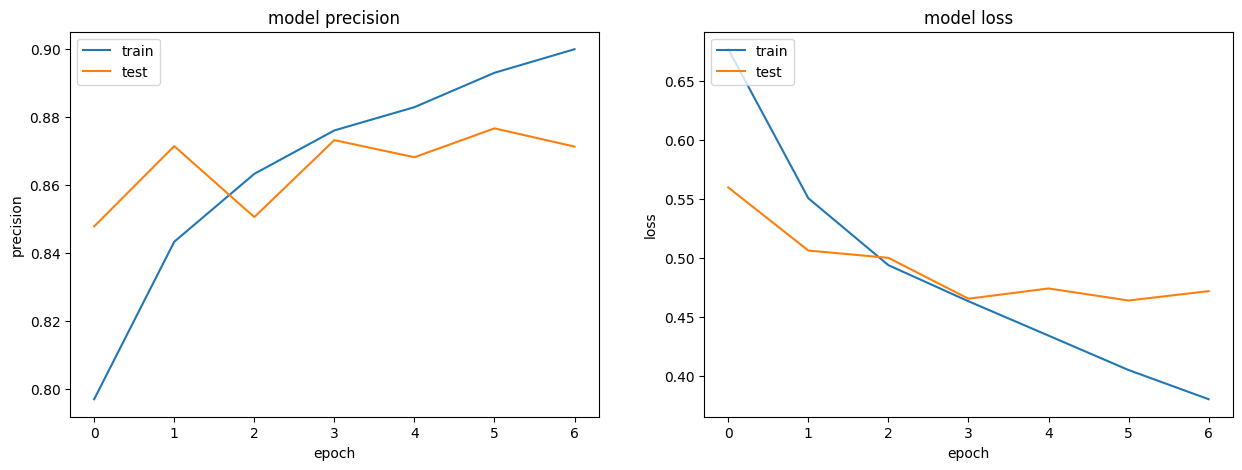

In [ ]:
# Source: in class lecture notebook 13a

%matplotlib inline
# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
  combined[key] = np.hstack([x.history[key] for x in model_xvec_histories])

# summarize history for precision
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## [2.0 points] Transfer Learning

I'm going to be preprocessing the data again using the BERT Preprocessor layer to ensure I'm feeding the data in correctly to the BERT model. The BERT model is expecting special tokens in my dataset, [CLS] and [SEP]. So I'll be using the BERT preprocessor to do that.

The majority of this code comes from an example on Kaggle: https://www.kaggle.com/code/dhruv1234/huggingface-tfbertmodel

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
!pip install tensorflow==2.12.0

BERT requirements for input conifguration can be provided by a built in tokenizer class. It performs the following:
 -  Tokenize the text
 -  Add special tokens described above
 -  create token IDs
 -  Pad sequences
 -  Create attention masks for the padded tokens

In [ ]:
# source: https://www.kaggle.com/code/dhruv1234/huggingface-tfbertmodel
# source: https://huggingface.co/transformers/v2.11.0/main_classes/tokenizer.html

import numpy as np

def bert_encode(data,maximum_length) :
  input_ids = []
  attention_masks = []


  for i in range(len(data.str_reviewText)):
      encoded = tokenizer.encode_plus( # built in huggingface class

        data.str_reviewText[i],
        add_special_tokens=True,
        max_length=maximum_length,
        truncation=True,
        pad_to_max_length=True,

        return_attention_mask=True,

      )

      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids),np.array(attention_masks)

In [ ]:
# Split my data at the top level so that I can have it in an un-encoded format for the BERT encoder
df_bert = pd.concat([df.str_reviewText,df.sentiment], axis=1)

In [ ]:
# Source: Modified from https://www.kaggle.com/code/dhruv1234/huggingface-tfbertmodel
# Because I want to stratify my data I'm keeping it together longer than the example,
# then splitting it using train_test_split.
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from sklearn.model_selection import train_test_split


# del df # memory management # temporary comment out
train_input_ids,train_attention_masks = bert_encode(df_bert,128) # BERT Max is 512, lowering for computational time concerns
# test_input_ids,test_attention_masks = bert_encode(test,26680) # hard coding MAX_REVIEW_LENGTH for now
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(df_bert.sentiment)
labels_encoded_ohe = keras.utils.to_categorical(labels_encoded)

train_input_ids, test_input_ids, train_attention_masks, test_attention_masks, train_labels, test_labels = train_test_split(
    train_input_ids, train_attention_masks, labels_encoded_ohe, train_size=0.8, test_size=0.2, stratify=labels_encoded_ohe
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
print(f"The datatype of the train_input_ids is ",{type(train_input_ids)})
print(f"The shape is ",{train_input_ids.shape}, "\n")

print(f"The datatype of the train_attention_masks is ",{type(train_attention_masks)})
print(f"The shape is ",{train_attention_masks.shape}, "\n")

print(f"The datatype of the labels_encoded is ",{type(train_labels)})
print(f"The shape is ",{train_labels.shape}, "\n")

print(f"The datatype of the train_input_ids is ",{type(test_input_ids)})
print(f"The shape is ",{test_input_ids.shape}, "\n")

print(f"The datatype of the train_attention_masks is ",{type(test_attention_masks)})
print(f"The shape is ",{test_attention_masks.shape}, "\n")

print(f"The datatype of the labels_encoded is ",{type(test_labels)})
print(f"The shape is ",{test_labels.shape}, "\n")

The datatype of the train_input_ids is  {<class 'numpy.ndarray'>}
The shape is  {(39806, 128)} 

The datatype of the train_attention_masks is  {<class 'numpy.ndarray'>}
The shape is  {(39806, 128)} 

The datatype of the labels_encoded is  {<class 'numpy.ndarray'>}
The shape is  {(39806, 3)} 

The datatype of the train_input_ids is  {<class 'numpy.ndarray'>}
The shape is  {(9952, 128)} 

The datatype of the train_attention_masks is  {<class 'numpy.ndarray'>}
The shape is  {(9952, 128)} 

The datatype of the labels_encoded is  {<class 'numpy.ndarray'>}
The shape is  {(9952, 3)} 



In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

def create_model(bert_model):
  input_ids = tf.keras.layers.Input(shape=(128,),dtype='int32')
  attention_masks = tf.keras.layers.Input(shape=(128,),dtype='int32')

  bert_model.trainable = False

  output = bert_model([input_ids,attention_masks])
  output = output[1]
  output = tf.keras.layers.Dense(64,activation='relu')(output)
  output = tf.keras.layers.Dropout(0.2)(output)
  output = tf.keras.layers.Dense(3,activation='softmax')(output)

  model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.Precision()])
  return model

TensorFlow version: 2.12.0


In [ ]:
from transformers import TFBertModel, BertConfig

bert_model = TFBertModel.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
bert_untrainable_model = create_model(bert_model)
bert_untrainable_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [ ]:
# from keras.callbacks import CSVLogger

csv_logger_bert_untrainable = CSVLogger('/content/drive/MyDrive/Colab Notebooks/bert_untrainable_training.csv', append=True)

bert_untrainable_histories = []
bert_untrainable_tmp = bert_untrainable_model.fit(
    [train_input_ids,train_attention_masks],
    train_labels,
    validation_data=([test_input_ids,test_attention_masks],test_labels),
    epochs=3,
    batch_size=128,
    callbacks=[csv_logger_bert_untrainable]
)

bert_untrainable_histories.append(bert_untrainable_tmp)

Epoch 1/3
311/311 [==============================] - 3321s 11s/step - loss: 0.6553 - precision: 0.7912 - val_loss: 0.5962 - val_precision: 0.7921
Epoch 2/3
311/311 [==============================] - 3394s 11s/step - loss: 0.5966 - precision: 0.8025 - val_loss: 0.5606 - val_precision: 0.7958
Epoch 3/3
311/311 [==============================] - 3397s 11s/step - loss: 0.5731 - precision: 0.8155 - val_loss: 0.5717 - val_precision: 0.7951


In [ ]:
bert_untrainable_tmp = bert_untrainable_model.fit(
    [train_input_ids,train_attention_masks],
    train_labels,
    validation_data=([test_input_ids,test_attention_masks],test_labels),
    epochs=3,
    batch_size=128,
    callbacks=[csv_logger_bert_untrainable]
)

bert_untrainable_histories.append(bert_untrainable_tmp)

Epoch 1/2
311/311 [==============================] - 3544s 11s/step - loss: 0.5662 - precision: 0.8234 - val_loss: 0.5362 - val_precision: 0.8215
Epoch 2/2
311/311 [==============================] - 3482s 11s/step - loss: 0.5579 - precision: 0.8263 - val_loss: 0.5491 - val_precision: 0.8076


In [ ]:
bert_untrainable_tmp = bert_untrainable_model.fit(
    [train_input_ids,train_attention_masks],
    train_labels,
    validation_data=([test_input_ids,test_attention_masks],test_labels),
    epochs=1,
    batch_size=128,
    callbacks=[csv_logger_bert_untrainable]
)

bert_untrainable_histories.append(bert_untrainable_tmp)

311/311 [==============================] - 3455s 11s/step - loss: 0.5510 - precision: 0.8291 - val_loss: 0.5408 - val_precision: 0.8133


In [ ]:
bert_untrainable_tmp = bert_untrainable_model.fit(
    [train_input_ids,train_attention_masks],
    train_labels,
    validation_data=([test_input_ids,test_attention_masks],test_labels),
    epochs=2,
    batch_size=128,
    callbacks=[csv_logger_bert_untrainable]
)

bert_untrainable_histories.append(bert_untrainable_tmp)

Epoch 1/2
311/311 [==============================] - 3403s 11s/step - loss: 0.5486 - precision: 0.8307 - val_loss: 0.5263 - val_precision: 0.8287
Epoch 2/2
311/311 [==============================] - 3409s 11s/step - loss: 0.5459 - precision: 0.8330 - val_loss: 0.5179 - val_precision: 0.8439


In [ ]:
bert_untrainable_tmp = bert_untrainable_model.fit(
    [train_input_ids,train_attention_masks],
    train_labels,
    validation_data=([test_input_ids,test_attention_masks],test_labels),
    epochs=3,
    batch_size=128,
    callbacks=[csv_logger_bert_untrainable]
)

bert_untrainable_histories.append(bert_untrainable_tmp)

NameError: name 'bert_untrainable_model' is not defined

In [ ]:
bert_untrainable_model.save_weights('/content/drive/MyDrive/Colab Notebooks/bert_untrainable_weights.h5') # colab
# bert_untrainable_model.save_weights('bert_untrainable_weights.h5') # local


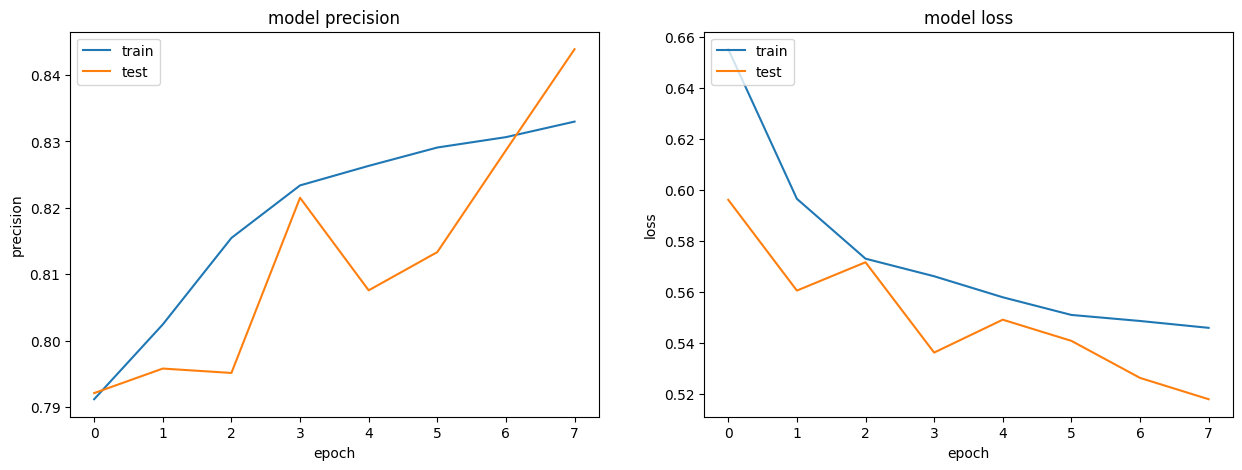

In [ ]:
# Source: in class lecture notebook 13a

%matplotlib inline
# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
  combined[key] = np.hstack([x.history[key] for x in bert_untrainable_histories])

# summarize history for precision
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Train a model by transfer learning from your foundational model.**

**Verify that the new model converges. You only need to train a model using the bottleneck features for this step.**

## [2.0 points] Fine Tuning

To determine where to start fine tuning, I'll take a look at the model layers for the BERT model.

In [ ]:
df_bert['enc_sentiment'] = label_encoder.fit_transform(df_bert['sentiment'])

In [ ]:
from transformers import AutoTokenizer, TFBertModel

df_train, df_test = train_test_split(df_bert, test_size=0.3, random_state=42,
                                     stratify=df_bert['sentiment'])

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

max_len = 128

X_train = tokenizer(
    text=df_train['str_reviewText'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_test = tokenizer(
    text=df_test['str_reviewText'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
# X_train['input_ids'] = tf.cast(X_train['input_ids'], tf.int32)
# X_test['input_ids'] = tf.cast(X_test['input_ids'], tf.int32)
# X_train['attention_mask'] = tf.cast(X_train['attention_mask'], tf.int32)
# X_test['attention_mask'] = tf.cast(X_test['attention_mask'], tf.int32)

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
# from tensorflow.keras.losses import CategoricalCrossentropy
# from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

embeddings = bert(input_ids, attention_mask = input_mask)[0] # 0 = last hidden state, 1 = poller_output
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(64, activation='relu')(out)
out = tf.keras.layers.Dropout(0.2)(out)
# out = Dense(32, activation='relu')(out)

y = Dense(3, activation='softmax')(out) # changed final layer to 3 to match categories

bert_trainable_model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
bert_trainable_model.layers[2].trainable = True

optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=5e-05, # HF recommendation
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0
)

loss = 'categorical_crossentropy'
metric = [tf.keras.metrics.Precision()]

bert_trainable_model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metric
)
bert_trainable_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

In [ ]:
csv_logger_bert_trainable = CSVLogger('/content/drive/MyDrive/Colab Notebooks/bert_trainable_training.csv', append=True)

bert_trainable_histories = []
bert_trainable_tmp = bert_trainable_model.fit(
    x = {'input_ids':X_train['input_ids'], 'attention_mask':X_train['attention_mask']},
    y = to_categorical(df_train['enc_sentiment']),
    validation_data = ({'input_ids':X_test['input_ids'], 'attention_mask':X_test['attention_mask']},
                        to_categorical(df_test['enc_sentiment'])),
    epochs=5,
    batch_size=128,
    callbacks=[csv_logger_bert_trainable]
)
bert_trainable_histories.append(bert_trainable_tmp)

Epoch 1/5
273/273 [==============================] - 6558s 24s/step - loss: 0.4899 - precision_1: 0.8598 - val_loss: 0.4270 - val_precision_1: 0.8905
Epoch 2/5
273/273 [==============================] - 6369s 23s/step - loss: 0.3836 - precision_1: 0.8925 - val_loss: 0.4039 - val_precision_1: 0.8866
Epoch 3/5
273/273 [==============================] - 6483s 24s/step - loss: 0.3335 - precision_1: 0.9031 - val_loss: 0.4104 - val_precision_1: 0.8760
Epoch 4/5
273/273 [==============================] - 6441s 24s/step - loss: 0.2963 - precision_1: 0.9127 - val_loss: 0.4254 - val_precision_1: 0.8656
Epoch 5/5
273/273 [==============================] - 6408s 23s/step - loss: 0.2673 - precision_1: 0.9195 - val_loss: 0.4367 - val_precision_1: 0.8613


In [ ]:
bert_trainable_model.save_weights('/content/drive/MyDrive/Colab Notebooks/bert_trainable_weights.h5') # colab
# bert_untrainable_model.save_weights('bert_untrainable_weights.h5') # local


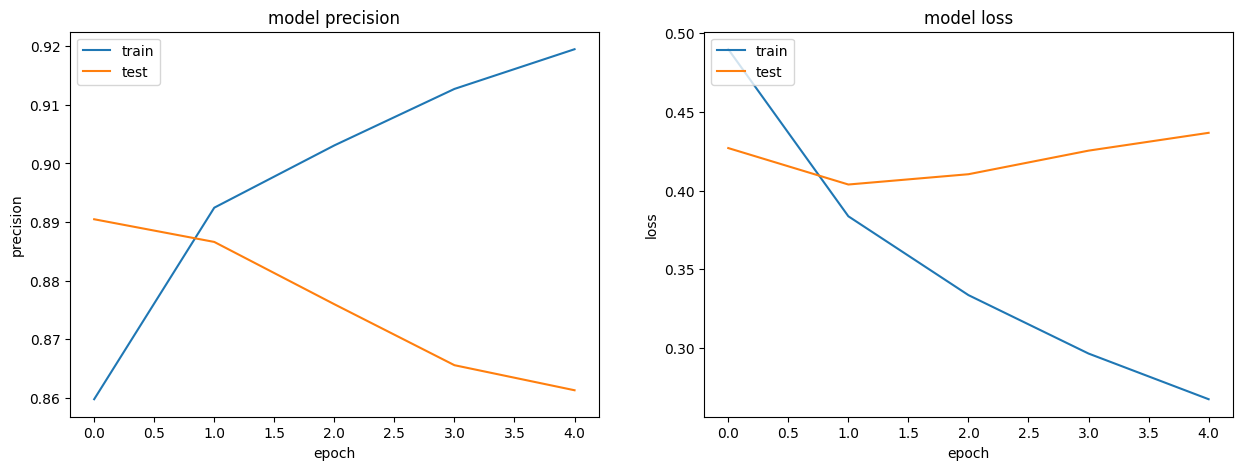

In [ ]:
# Source: in class lecture notebook 13a

%matplotlib inline
# combine all the history from training together
combined = dict()
for key in ['precision_1','val_precision_1','loss','val_loss']:
  combined[key] = np.hstack([x.history[key] for x in bert_trainable_histories])

# summarize history for precision
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision_1'])
plt.plot(combined['val_precision_1'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Perform fine tuning upon the model by training some layers within the foundational model**

**Verify that the model converges.**

## [4.0 points] Report the results

**Report the results of all models using the evaluation procedure that you argued for at the beginning of the lab.**

**Compare the convergence of the models and the running time.**

**Results should be reported with proper statistical comparisons and proper visualizations.**

## Sources

In [ ]:
https://www.tensorflow.org/text/tutorials/classify_text_with_bert
https://keras.io/examples/nlp/pretraining_BERT/
https://www.smashwords.com/about
https://huggingface.co/google-bert/bert-base-uncased?text=The+goal+of+a+dog%27s+life+is+%5BMASK%5D.
https://keras.io/guides/keras_nlp/transformer_pretraining/
https://huggingface.co/transformers/v3.3.1/pretrained_models.html
https://www.analyticsvidhya.com/blog/2021/05/all-you-need-to-know-about-bert/#:~:text=The%20BERTBase%20model%20uses,has%20around%20110M%20trainable%20parameters.